Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Mount Google Drive

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Initialise Train and Test Data Directories

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/MelanomaDetection/Data/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/MelanomaDetection/Data/Test")

### Check number of imgaes in both Train and Test directories

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
## Setting the image size variable to 180x180
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Images will be resized your img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training',
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [8]:
## validation dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# List of all the classes of skin cancer
# These also correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Here we visualize one instance of all the nine classes present in the dataset

32
32


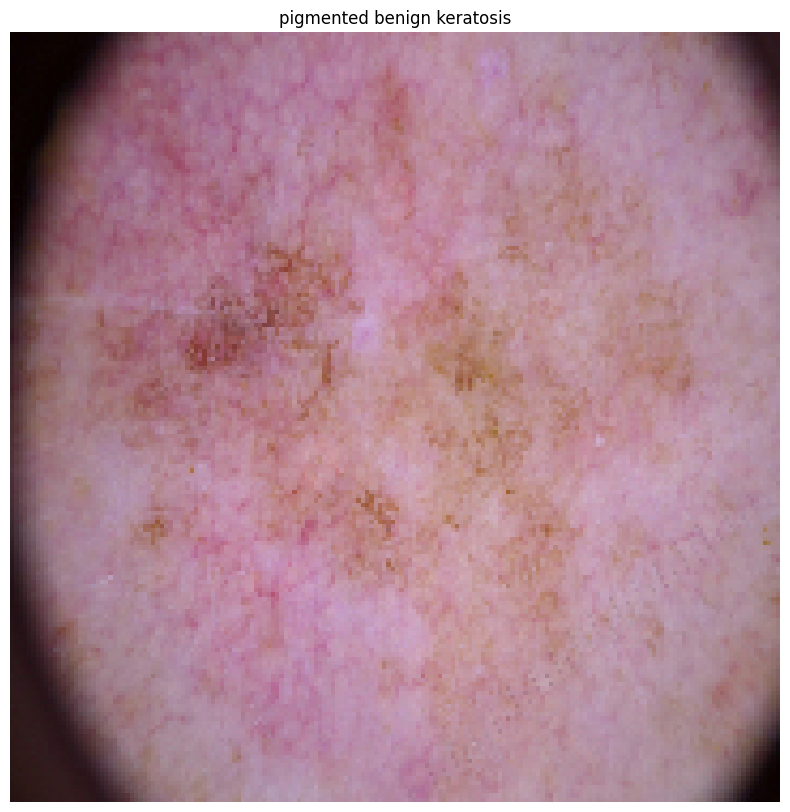

In [10]:
import matplotlib.pyplot as plt
import cv2

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")


Class: actinic keratosis, Number of images: 114
Class: basal cell carcinoma, Number of images: 376
Class: dermatofibroma, Number of images: 95
Class: melanoma, Number of images: 438
Class: nevus, Number of images: 357
Class: pigmented benign keratosis, Number of images: 462
Class: seborrheic keratosis, Number of images: 77
Class: squamous cell carcinoma, Number of images: 191
Class: vascular lesion, Number of images: 139


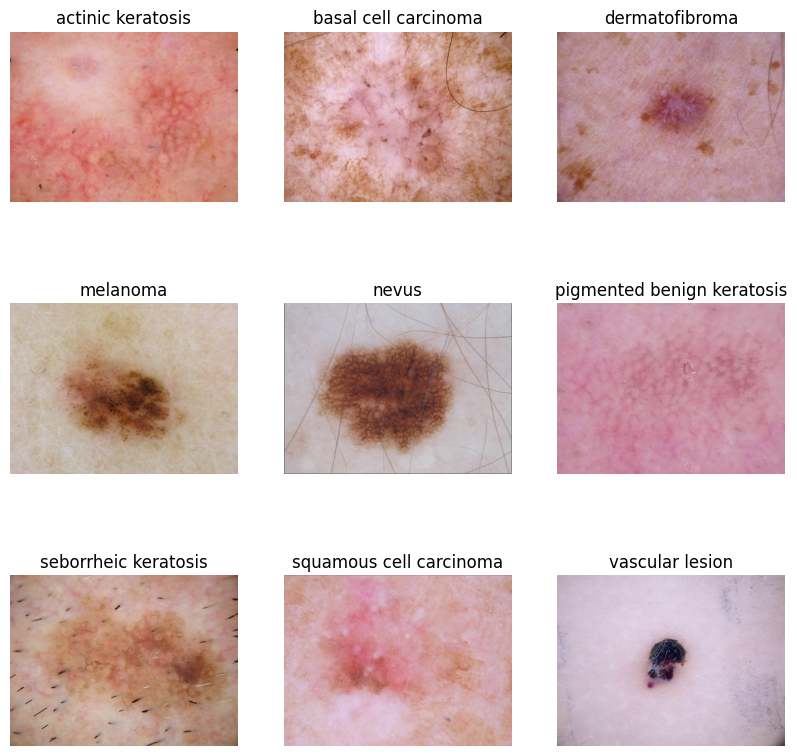

In [11]:
class_names = train_ds.class_names
#print(class_names)

files_path_dict = {}
for c in class_names:
    files_path_dict[c] = list(map(lambda x: os.path.join(data_dir_train, c, x), os.listdir(os.path.join(data_dir_train, c))))
    print(f"Class: {c}, Number of images: {len(files_path_dict[c])}")

plt.figure(figsize=(10, 10))
index = 0
for c in class_names:
  path_list = files_path_dict[c][:1]
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(plt.imread(path_list[0]))
  plt.title(c)
  plt.axis("off")

Because we use the batch size as 32, we will be using a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Below is a simple baseline model to detect the 9 classes. Here we will be normalizing pixel values between [0, 1] as the RGB values are in [255, 255]

In [13]:
### Base CNN model here

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
###  We will use Adam optimiser and Crossentropy loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.2068 - loss: 2.1645 - val_accuracy: 0.2695 - val_loss: 1.9539
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 18ms/step - accuracy: 0.3282 - loss: 1.8704 - val_accuracy: 0.4878 - val_loss: 1.6104
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4420 - loss: 1.5618 - val_accuracy: 0.4610 - val_loss: 1.4766
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5174 - loss: 1.3445 - val_accuracy: 0.5056 - val_loss: 1.3903
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5371 - loss: 1.3264 - val_accuracy: 0.4788 - val_loss: 1.4946
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5704 - loss: 1.1978 - val_accuracy: 0.5278 - val_loss: 1.3523
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6293 - loss: 1.0532 - val_accuracy: 0.5390 - val_loss: 1.4100
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6581 - loss: 0.9867 - val_accuracy: 0.5479 - 

### Visualizing training results

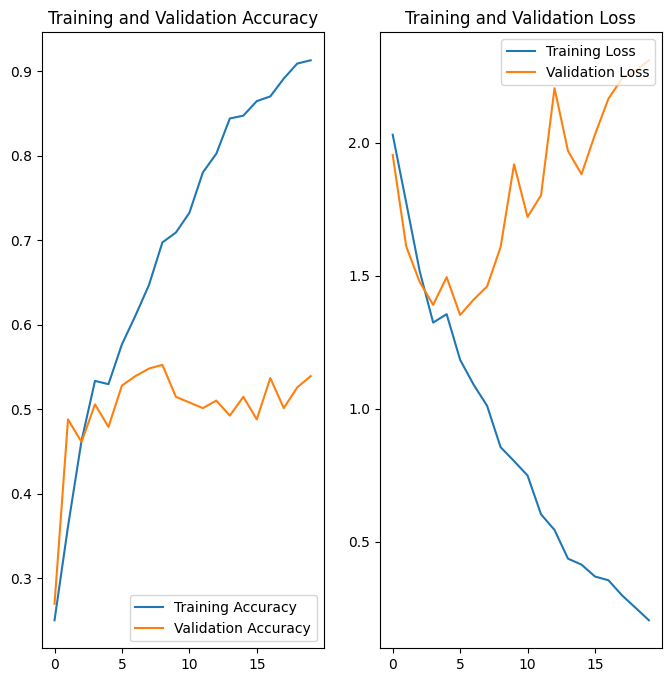

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  Findings from the base model -
1. Inital epochs,Validation Accuracy as close as Training Accuracy.This is where the Training Accuracy close to 0.5
2. As the Training Accuracy keeps going up, Validation Accuracy stays same.
3. This is clearly the case of overfitting.
4. We need to try augmentation for these images.
5. Also, there is class imbalance present.

### Write your findings here

In [18]:
#from tensorflow import keras
#from tensorflow.keras import layers

## Here we use below augmentation strategy based on the domain specific requirements of the image processing
### Random Rotation
### Random Zoom
### Random Contrast
### Random Brightness
### Random Crop
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    #layers.RandomWidth(0.1),
    #layers.RandomHeight(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    #layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)

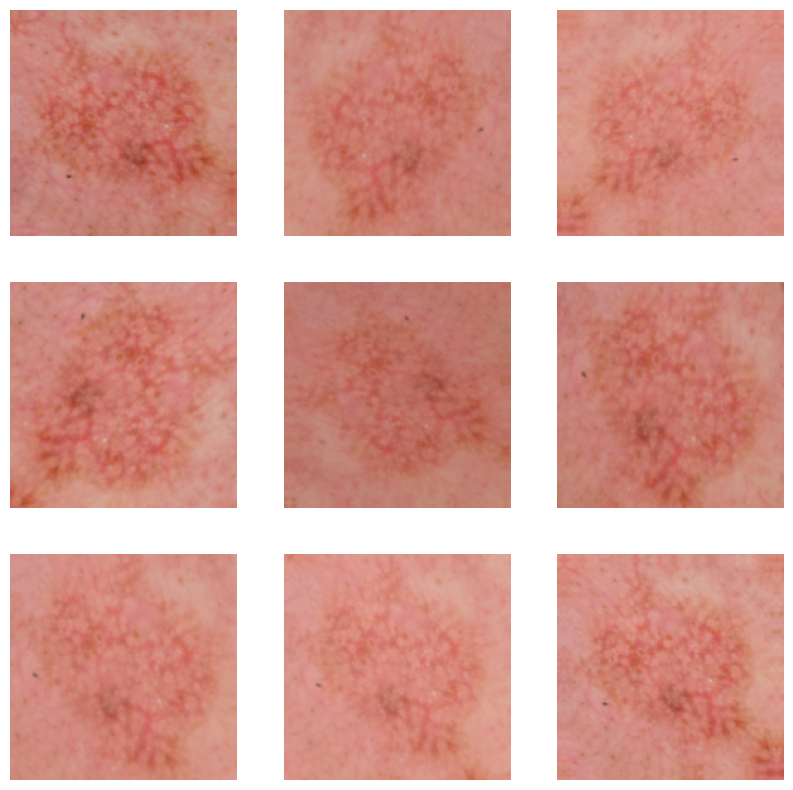

In [19]:
# Visualize how augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create
### Create the model, compile and train the model


In [20]:
## Tuning added to the model -
### Data Augmentation
### Drop out layer


model = Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9))

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [21]:
## Let's compile the model
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Training the model

In [22]:
## Let's train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1592 - loss: 3.2751 - val_accuracy: 0.1871 - val_loss: 2.0349
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2345 - loss: 1.9780 - val_accuracy: 0.3296 - val_loss: 1.9264
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3656 - loss: 1.8135 - val_accuracy: 0.4187 - val_loss: 1.6725
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3946 - loss: 1.6382 - val_accuracy: 0.4143 - val_loss: 1.6481
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4416 - loss: 1.6244 - val_accuracy: 0.4633 - val_loss: 1.5370
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4705 - loss: 1.5143 - val_accuracy: 0.4454 - val_loss: 1.5379
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4713 - loss: 1.5099 - val_accuracy: 0.4454 - val_loss: 1.5638
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5067 - loss: 1.4033 - val_accuracy: 0.4521 - v

### Visualizing the results

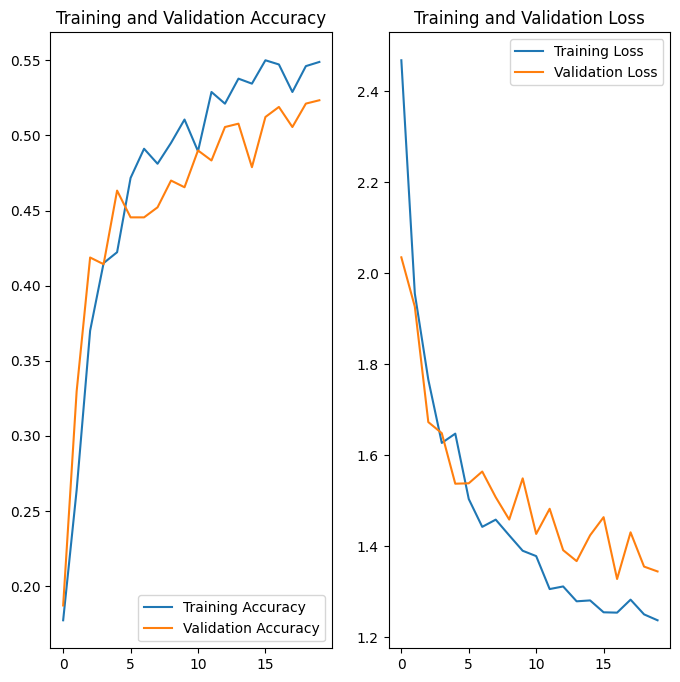

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings after the model fit

#### Given the gap between Training Accuracy and Validation Accuracy is consistent, it does not seem to be the case of overfitting
#### However overall Training Accuracy has not crossed 0.55 in the epochs.
#### We also see class imbalance across 9 classes. We need to address it before fitting the model

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:

## Check the class distribution
def class_distribution(data_dir):
    count = []
    for path in pathlib.Path(data_dir).iterdir():
        if path.is_dir():
            #count.append(len(list(path.glob('*'))))
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))


    sub_directory = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

    return pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])


df = class_distribution(data_dir_train)
df



,Class,No. of Images
0,melanoma,438
1,pigmented benign keratosis,462
2,vascular lesion,139
3,nevus,357
4,seborrheic keratosis,77
5,actinic keratosis,114
6,squamous cell carcinoma,191
7,dermatofibroma,95
8,basal cell carcinoma,376


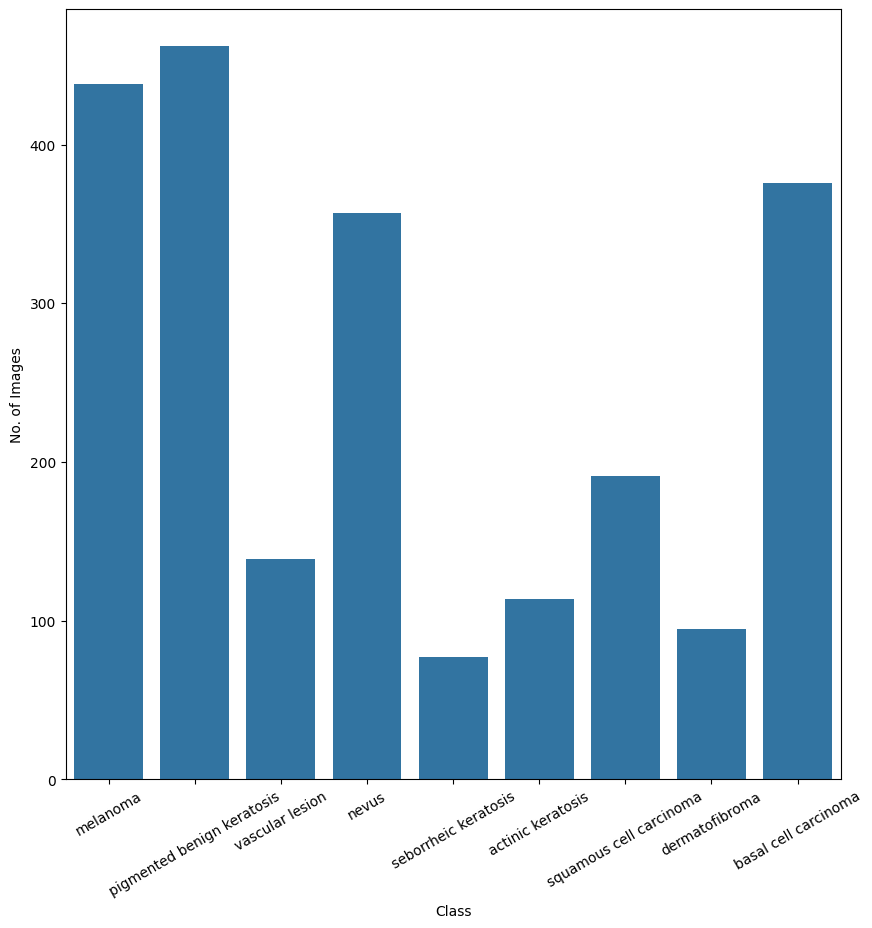

In [25]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x='Class', y='No. of Images', data=df)
plt.xticks(rotation=30)
plt.show()

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2249

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/MelanomaDetection/Data...,melanoma
1,/content/gdrive/MyDrive/MelanomaDetection/Data...,melanoma
2,/content/gdrive/MyDrive/MelanomaDetection/Data...,melanoma
3,/content/gdrive/MyDrive/MelanomaDetection/Data...,melanoma
4,/content/gdrive/MyDrive/MelanomaDetection/Data...,melanoma
...,...,...
2244,/content/gdrive/MyDrive/MelanomaDetection/Data...,basal cell carcinoma
2245,/content/gdrive/MyDrive/MelanomaDetection/Data...,basal cell carcinoma
2246,/content/gdrive/MyDrive/MelanomaDetection/Data...,basal cell carcinoma
2247,/content/gdrive/MyDrive/MelanomaDetection/Data...,basal cell carcinoma


Class=3, n=438 (19.475%)
Class=5, n=462 (20.542%)
Class=8, n=139 (6.181%)
Class=4, n=357 (15.874%)
Class=6, n=77 (3.424%)
Class=0, n=114 (5.069%)
Class=7, n=191 (8.493%)
Class=2, n=95 (4.224%)
Class=1, n=376 (16.719%)


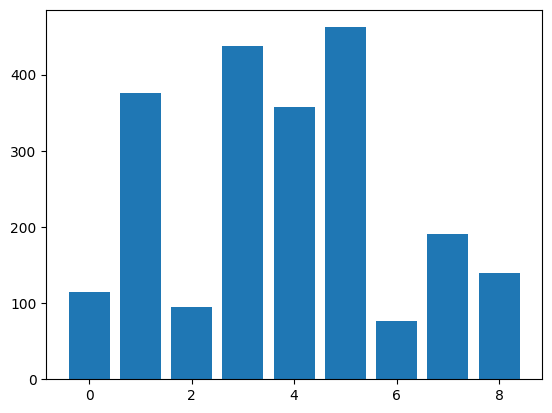

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### **Class Distribution Findings**
#### 'Seborrheic Keratosis' has the least number of samples with only 3.24% of the total images
#### These classes dominate the volumes of the samples - 'melanoma', 'pigmented benign keratosis', 'nevus', 'basal cell carcinoma'


#### Rectify the class imbalance
#### **Context:** We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset='/content/gdrive/MyDrive/MelanomaDetection/Data/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879B1B69B70>: 100%|██████████| 500/500 [00:31<00:00, 15.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879B06B4940>: 100%|██████████| 500/500 [00:26<00:00, 19.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879B1A2B280>: 100%|██████████| 500/500 [00:19<00:00, 25.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7879CEF60A90>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7879B069DF90>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879CEFB6860>: 100%|██████████| 500/500 [00:18<00:00, 26.92 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7879B1B69B70>: 100%|██████████| 500/500 [00:41<00:00, 12.16 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7879B069E6B0>: 100%|██████████| 500/500 [00:19<00:00, 25.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/MelanomaDetection/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787A4F79EEF0>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
## Check the images from output folder

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new


In [33]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [37]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,691
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [38]:
new_df.columns

Index(['Path', 'Label'], dtype='object')

Class=3, n=938 (13.898%)
Class=5, n=962 (14.254%)
Class=8, n=639 (9.468%)
Class=4, n=857 (12.698%)
Class=6, n=577 (8.549%)
Class=0, n=614 (9.098%)
Class=7, n=691 (10.239%)
Class=2, n=595 (8.816%)
Class=1, n=876 (12.980%)


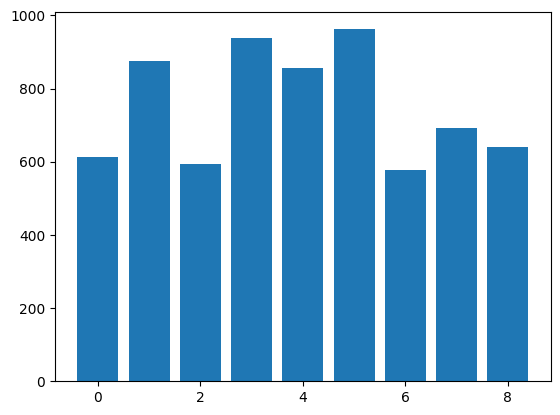

In [39]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = new_df['Path'], new_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

In [41]:
#glob(os.path.join(data_dir_train, '*','output', '*.jpg'))
data_dir_train

PosixPath('/content/gdrive/MyDrive/MelanomaDetection/Data/Train')

#### **Todo:** Create a training dataset

In [42]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here

model_augmented = Sequential()
model_augmented.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model_augmented.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model_augmented.add(layers.MaxPooling2D())
model_augmented.add(layers.Dropout(0.2))

model_augmented.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model_augmented.add(layers.MaxPooling2D())
model_augmented.add(layers.Dropout(0.2))

model_augmented.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model_augmented.add(layers.MaxPooling2D())
model_augmented.add(layers.Dropout(0.2))

model_augmented.add(layers.Flatten())
model_augmented.add(layers.Dense(128, activation='relu'))
model_augmented.add(layers.Dense(9))

model_augmented.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the model (Choose optimizer and loss function appropriately)

In [46]:

model_augmented.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### Train the model

In [47]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 146ms/step - accuracy: 0.1700 - loss: 2.4765 - val_accuracy: 0.3047 - val_loss: 1.8415
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3740 - loss: 1.6465 - val_accuracy: 0.4781 - val_loss: 1.4587
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4661 - loss: 1.3896 - val_accuracy: 0.4248 - val_loss: 1.5527
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5280 - loss: 1.2620 - val_accuracy: 0.4514 - val_loss: 1.4572
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5675 - loss: 1.1799 - val_accuracy: 0.5486 - val_loss: 1.1885
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6155 - loss: 1.0371 - val_accuracy: 0.5871 - val_loss: 1.1101
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6481 - loss: 0.9481 - val_accuracy: 0.6123 - val_loss: 1.1446
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7090 - loss: 0.7983 - val_ac

#### **Todo:**  Visualize the model results

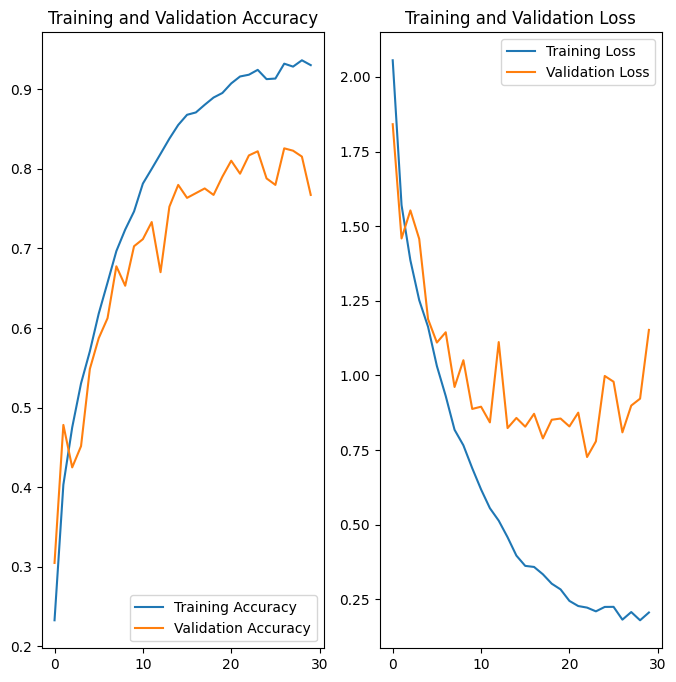

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of the results here.
1. As we see in above graphs, Training Accuracy and Validation Accuracy are comparable.
2. Also these accuracies are above 0.8
3. Class Rebalance has helped to close the gap between Training and Validation accuracies.


In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [50]:
model_augmented.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.3254 - loss: 10.9203


[10.0557861328125, 0.31355932354927063]

In [51]:
epochs = 50
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9110 - loss: 0.2156 - val_accuracy: 0.7131 - val_loss: 1.6665
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9134 - loss: 0.2353 - val_accuracy: 0.7872 - val_loss: 1.0359
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9480 - loss: 0.1403 - val_accuracy: 0.8236 - val_loss: 0.9709
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9436 - loss: 0.1469 - val_accuracy: 0.8154 - val_loss: 0.9117
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9357 - loss: 0.1702 - val_accuracy: 0.7991 - val_loss: 0.9236
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9458 - loss: 0.1332 - val_accuracy: 0.8295 - val_loss: 0.9545
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9433 - loss: 0.1448 - val_accuracy: 0.8184 - val_loss: 0.8513
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9476 - loss: 0.1373 - val_accu

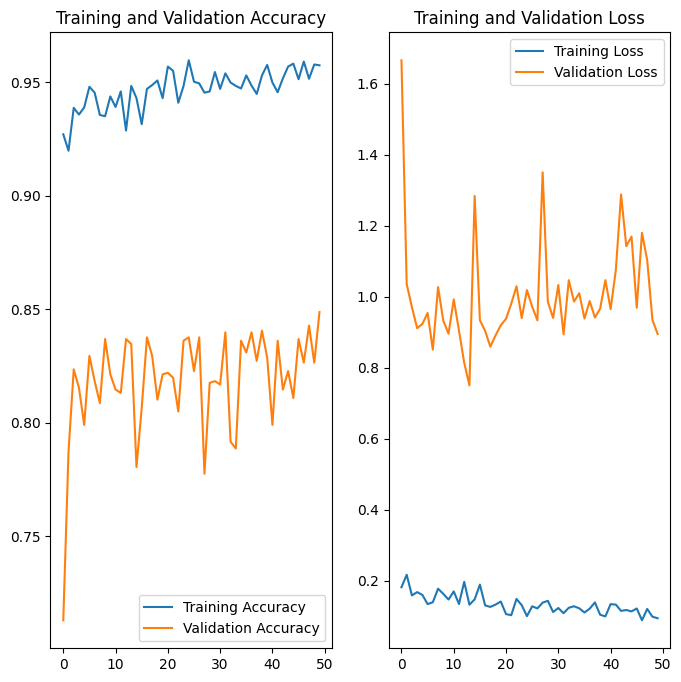

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
model_augmented.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 917ms/step - accuracy: 0.3442 - loss: 11.2217


[10.907388687133789, 0.347457617521286]